In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import shutil
import warnings
import os
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df = pd.read_excel("../datasets/AEP_hourly_processed.xlsx")

df = df.drop(columns=["Unnamed: 0"], errors="ignore")

df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.sort_values("Datetime")
df.set_index("Datetime", inplace=True)

df = df[["AEP_MW"]]

df = df.iloc[:5000]

train_size = int(len(df) * 0.8)
df_train_raw = df.iloc[:train_size]
df_test_raw = df.iloc[train_size:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train_raw)
scaled_test = scaler.transform(df_test_raw)

df_train = pd.DataFrame(scaled_train, columns=df.columns, index=df_train_raw.index)
df_test = pd.DataFrame(scaled_test, columns=df.columns, index=df_test_raw.index)

print(f"Training data size: {len(df_train)}")
print(f"Testing data size: {len(df_test)}")

Training data size: 4000
Testing data size: 1000


In [4]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [5]:
X_train, y_train = create_sequences(scaled_train)
X_test, y_test = create_sequences(scaled_test)

X_train_2d = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test_2d = X_test.reshape((X_test.shape[0], X_test.shape[1]))

In [6]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train_2d, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [7]:
train_pred = model.predict(X_train_2d).reshape(-1, 1)
train_pred_inv = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
print(f"Train RMSE: {train_rmse:.4f}")

Train RMSE: 134.6766


In [8]:
pred_path = "predictions/Energy_XGBoost_train.npy"
os.makedirs("predictions", exist_ok=True)
np.save(pred_path, train_pred_inv)

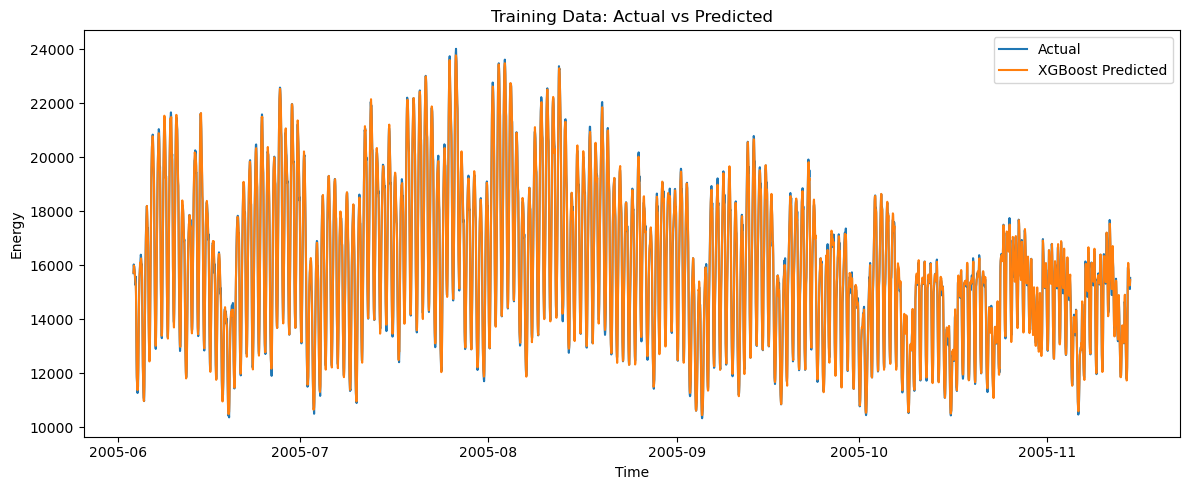

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(df_train_raw.index[-len(train_pred_inv):], y_train_inv, label='Actual')
plt.plot(df_train_raw.index[-len(train_pred_inv):], train_pred_inv, label='XGBoost Predicted')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
test_pred = model.predict(X_test_2d).reshape(-1, 1)
test_pred_inv = scaler.inverse_transform(test_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 507.8945


In [11]:
dataset_name = "Energy"
rmse_file = "RMSE_XGBoost.json"

try:
    with open(rmse_file, "r") as f:
        rmse_data = json.load(f)
except FileNotFoundError:
    rmse_data = {}

rmse_data[dataset_name] = round(test_rmse, 2)

with open(rmse_file, "w") as f:
    json.dump(rmse_data, f, indent=4)

In [12]:
pred_path = "predictions/Energy_XGBoost_test.npy"
os.makedirs("predictions", exist_ok=True)
np.save(pred_path, test_pred_inv)

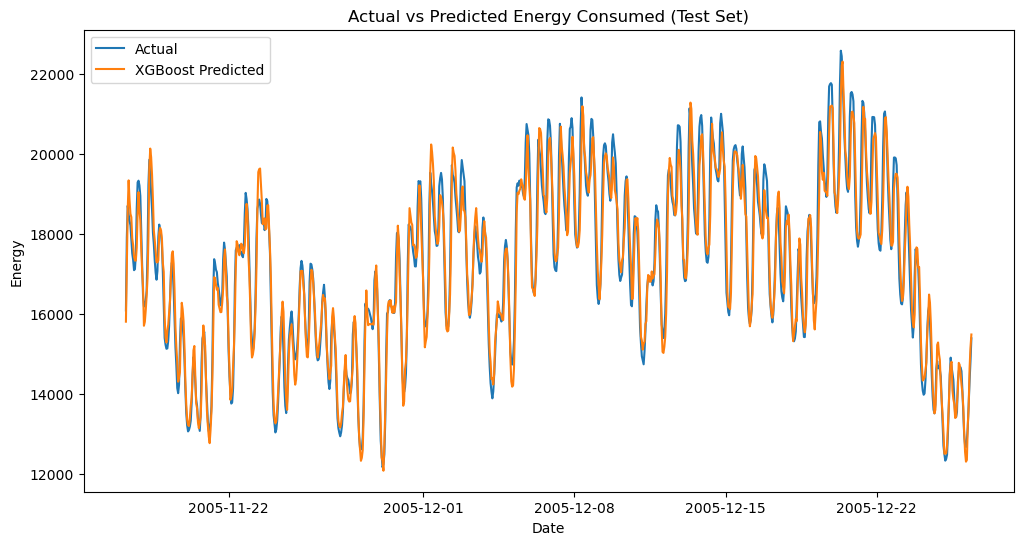

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_test_raw.index[-len(test_pred_inv):], y_test_inv, label='Actual')
plt.plot(df_test_raw.index[-len(test_pred_inv):], test_pred_inv, label='XGBoost Predicted')
plt.title('Actual vs Predicted Energy Consumed (Test Set)')
plt.xlabel('Date')
plt.ylabel('Energy')
plt.legend()
plt.show()